In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.ner_metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.gpt2_generation import GPT2GenerationAnonymization
from models.gpt2_model import PretrainedGPT2TextInfilling
from mask.personal_entity import MaskEntityType

In [3]:
set_seed(42)

In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
bert_large_model_config["model_version"] = 19

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на анонимизированном с помощью справочников тренировочном наборе данных i2b2 2014 без учёта регистра
    6. Version 5 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2014 без учёта регистра, (11) GPT2 обучено на тренировочном наборе данных i2b2 2014 
    7. Version 6 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2006 без учёта регистра, (11) GPT2 обучено на тренировочном наборе данных i2b2 2014 
    8. Version 7 --- обученная на нетронутом валидационном наборе данных i2b2 2014 без учёта регистра
    9. Version 8 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2006 без учёта регистра, (12) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2006
    10. Version 9 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2014 без учёта регистра, (12) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2014
    11. Version 10 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра (окно 256 токенов)
    12. Version 11 --- обученная на нетронутом валидационном наборе данных i2b2 2014 без учёта регистра (окно 256 токенов)
    13. Version 12 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2014 без учёта регистра, (20) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2014
    14. Version 13 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2006 без учёта регистра, (20) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2006
    15. Version 14 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2014 без учёта регистра, (21) GPT2 обучен с помощью RL
    16. Version 15 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2006 без учёта регистра, (21) GPT2 обучен с помощью RL
    17. Version 16 --- бесмысленный эксперимент: заменить в тренировочном наборе данных личные сущности на случайные из валидационного набора данных (на примере i2b2 2014, train и validate поменяли местами)
    18. Version 17 --- обученная на тренировочном наборе данных i2b2 2006, анонимизированном с помощью именованных сущностей из набора данных i2b2 2014, без учёта регистра 

### Этап 1: Обучение NER на анонимизированных с помощью ILM наборе данных i2b2-2014

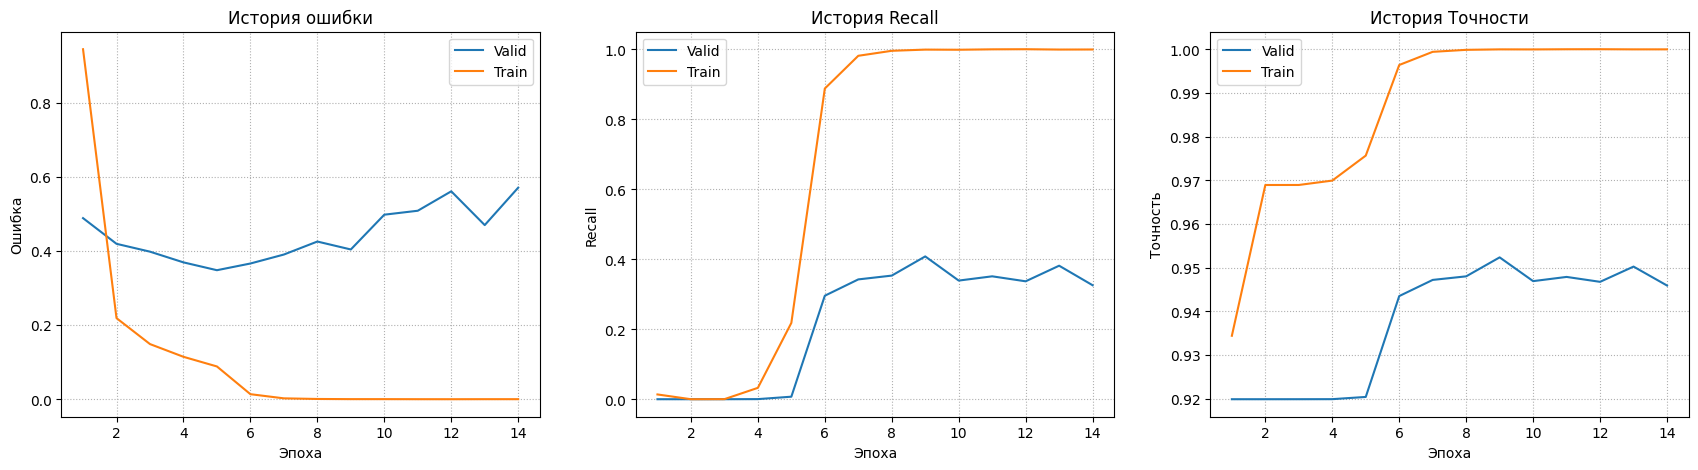

In [7]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(bert_large_model_config["model_version"])

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [8]:
# Data processing
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["train_data_path"], device='cpu', **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(bert_large_model_config["model_version"])
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=

In [10]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9513376355171204
     test_precision         0.9513376355171204
       test_recall          0.23777146637439728
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.23777146637439728,
  'test_precision': 0.9513376355171204,
  'test_f1': 0.9513376355171204}]

Computing predictions:   0%|          | 0/448 [00:00<?, ?it/s]

Uniting records:   0%|          | 0/790 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        NAME     0.9550    0.7333    0.8296     12814
  PROFESSION     0.0000    0.0000    0.0000       512
    LOCATION     0.6643    0.1438    0.2364      7116
         AGE     0.0000    0.0000    0.0000      1320
        DATE     0.8395    0.1207    0.2110     33592
          ID     0.3266    0.1808    0.2327      4769
     CONTACT     0.4727    0.0687    0.1200      1514

   micro avg     0.8097    0.2505    0.3826     61637
   macro avg     0.4654    0.1782    0.2328     61637
weighted avg     0.7696    0.2505    0.3357     61637



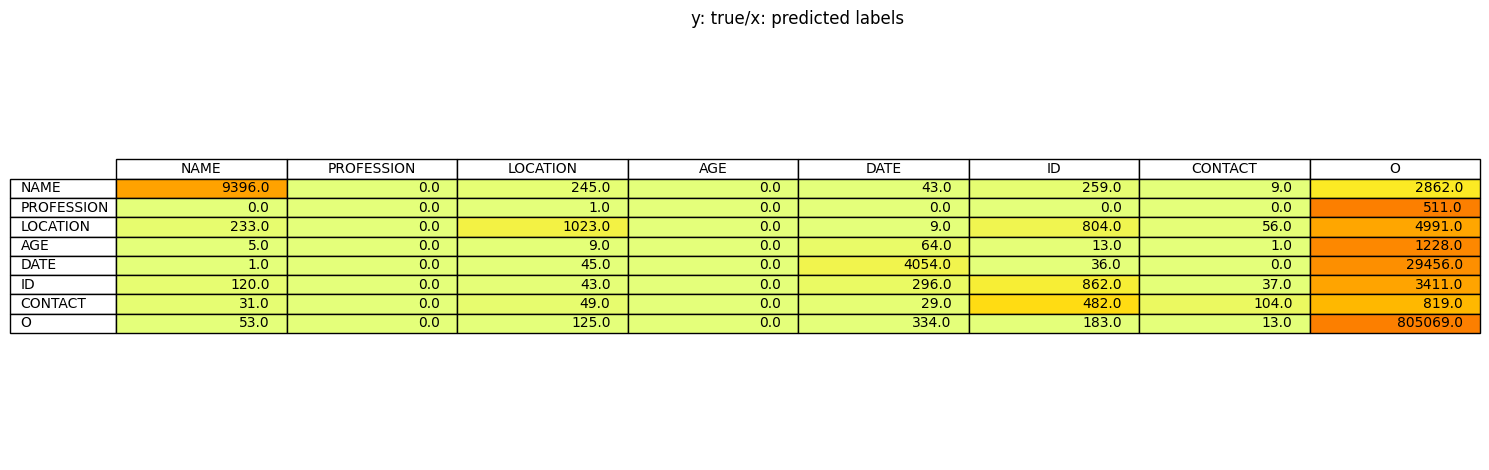

Wrongly predicted examples:
_____ Record 296-04 _____
| Sentence:    | record date : | 2100 - 07 - 07 | humalog 0 - 2 / 4 - 8 / 6 - 10 | 111 - 64 - 17 | lantus 10 u hs | xayarath, nancy | prograf 2 mg bid imuran 100 mg qhs prednisone 2. 5 mg qd starting last week omeprazole 20 mg qd lipitor 40 mg qd toprol xl 25 mg qpm imdur 30 mg qd coumadin 4 mg tablets ( for svc stent ) : 4 mg 2 / 7 ; 6 mg 5 / 7 asa 325 mg qd caltrate with d 1200 - 1500 mg per day in divided doses fosamax 70 mg qw centrum qd folate 1 mg qd not taking celexa 20 mg qd | july 07, 2100 | interim history : comes to review her medical problems. she had been losing weight and feeling fatigued. she has been at her current weight for several weeks and feels that she has stabilized. appetite has been good. home blood tests : no records. she reports that she drops from the 200's to the normal range in the morning. her bedtime test is about 3 - 4 hours after summer. retinopathy : saw dr. | xiques | in the | spring | . may need 

In [11]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [12]:
stats.get_specific_failed_predictions('PROFESSION')

Wrongly predicted examples:
_____ Record 252-04 _____
| Sentence:    | record date : | 2071 - 07 - 20 | edvisit ^ | 15842112 | ^ | joshi, kathy | ^ | 07 / 20 / 71 | ^ | katz, laura | this patient was seen, interviewed, and examined by myself primarily. history of present illness : this is a | 65  | - year - old female who presents with body swelling and shortness of breath. the patient is unable to say when she specifically noted her lower extremity swelling. she states that approximately 1 year prior to arrival she had to throw out all of her shoes except for 2 pairs because all those shoes had become tight. at the present time, the patient is only able to wear sandals and apparently her co - workers noted her to be significantly swollen and suggested that she see a physician. the patient states that there was no acute change in her swelling today. she states that she has had a cough for 1 month. again, there was no acute change. today, she denies any chest pain at any time. she does 

['100-01',
 '100-03',
 '102-03',
 '105-01',
 '106-01',
 '106-02',
 '106-03',
 '106-04',
 '108-01',
 '108-02',
 '108-03',
 '108-04',
 '120-01',
 '120-02',
 '125-01',
 '125-02',
 '125-03',
 '126-01',
 '126-02',
 '126-05',
 '127-03',
 '127-04',
 '127-05',
 '128-01',
 '128-04',
 '128-05',
 '129-05',
 '141-02',
 '141-04',
 '142-01',
 '142-02',
 '142-03',
 '142-04',
 '144-04',
 '145-02',
 '145-03',
 '145-04',
 '145-05',
 '146-03',
 '146-04',
 '147-03',
 '147-05',
 '149-03',
 '149-04',
 '151-02',
 '151-04',
 '154-04',
 '158-03',
 '158-04',
 '170-03',
 '170-04',
 '170-05',
 '171-02',
 '173-01',
 '173-02',
 '174-01',
 '174-02',
 '174-03',
 '174-04',
 '174-05',
 '175-03',
 '175-04',
 '176-01',
 '176-04',
 '177-04',
 '178-01',
 '179-03',
 '179-04',
 '185-03',
 '186-02',
 '187-01',
 '187-02',
 '187-03',
 '187-04',
 '188-02',
 '188-05',
 '189-05',
 '220-03',
 '220-04',
 '220-05',
 '221-01',
 '221-05',
 '223-02',
 '223-03',
 '223-04',
 '224-01',
 '225-02',
 '226-01',
 '226-02',
 '226-04',
 '227-01',

In [13]:
stats.get_specific_failed_predictions('CONTACT')

Wrongly predicted examples:
_____ Record 365-02 _____
| Sentence:    | record date : | 2071 - 04 - 11 | burn surgery admission h & p date / time : | 4 / 11 / 71 | , 9am * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * name : | rivers, karsten | mrn # | 95718084 | resident : | gillis | attending : | michael | * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * cc : burn to r foot hpi : | 44  | yo diabetic m with peripheral neuropathy, fell asleep in front of space heater approximately 3 weeks ago and noted swelling / blisters at tips of r 1st - 3rd toes upon waking. his wounds have been managed until this time by his podiatrist and his mother ( a former | doctor     | ) has been doing dressing changes at home - initially with silvadene but over the past several days with? betadine as directed by his podiatrist. the pt is a | floor covering installer | , and has been bearing weight 

['100-04',
 '100-05',
 '102-05',
 '104-03',
 '106-04',
 '107-04',
 '109-02',
 '109-04',
 '121-04',
 '122-05',
 '125-03',
 '126-01',
 '126-03',
 '127-03',
 '127-04',
 '127-05',
 '128-04',
 '129-04',
 '140-03',
 '140-05',
 '141-02',
 '145-02',
 '145-03',
 '145-04',
 '145-05',
 '146-03',
 '146-04',
 '147-04',
 '148-03',
 '148-04',
 '148-05',
 '149-03',
 '151-01',
 '151-03',
 '152-03',
 '155-03',
 '156-03',
 '157-03',
 '158-03',
 '158-04',
 '170-03',
 '170-04',
 '170-05',
 '171-05',
 '172-01',
 '172-02',
 '172-03',
 '172-04',
 '173-01',
 '175-04',
 '176-03',
 '177-01',
 '177-04',
 '177-05',
 '178-04',
 '179-02',
 '179-03',
 '181-03',
 '182-04',
 '182-05',
 '184-03',
 '184-04',
 '187-01',
 '187-03',
 '187-04',
 '189-05',
 '221-01',
 '221-04',
 '221-05',
 '224-01',
 '224-02',
 '224-03',
 '224-04',
 '225-02',
 '225-03',
 '240-03',
 '240-04',
 '242-03',
 '243-03',
 '244-01',
 '244-02',
 '247-01',
 '247-03',
 '248-02',
 '248-04',
 '250-03',
 '250-04',
 '251-03',
 '252-03',
 '254-02',
 '254-05',

**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных:

### Этап 2: Обучение NER на анонимизированных с помошью ILM данных из набора данных i2b2-2006

In [14]:
# Data processing
test_dataset = get_ner_dataset(path_to_folder=i2b2_2006_data_config["validate_data_path"], device='cpu', **i2b2_2006_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2006_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


In [15]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9523537755012512
     test_precision         0.9523537755012512
       test_recall          0.4079509675502777
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.4079509675502777,
  'test_precision': 0.9523537755012512,
  'test_f1': 0.9523537755012512}]

Computing predictions:   0%|          | 0/121 [00:00<?, ?it/s]

Uniting records:   0%|          | 0/220 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        NAME     0.9906    0.7646    0.8630      6610
  PROFESSION     0.0000    0.0000    0.0000         0
    LOCATION     0.8851    0.1913    0.3146      3664
         AGE     0.0000    0.0000    0.0000         6
        DATE     0.9060    0.1901    0.3142      5224
          ID     0.9402    0.2376    0.3794      5361
     CONTACT     0.9935    0.3741    0.5435       409

   micro avg     0.9619    0.3843    0.5492     21274
   macro avg     0.6736    0.2511    0.3450     21274
weighted avg     0.9387    0.3843    0.5056     21274



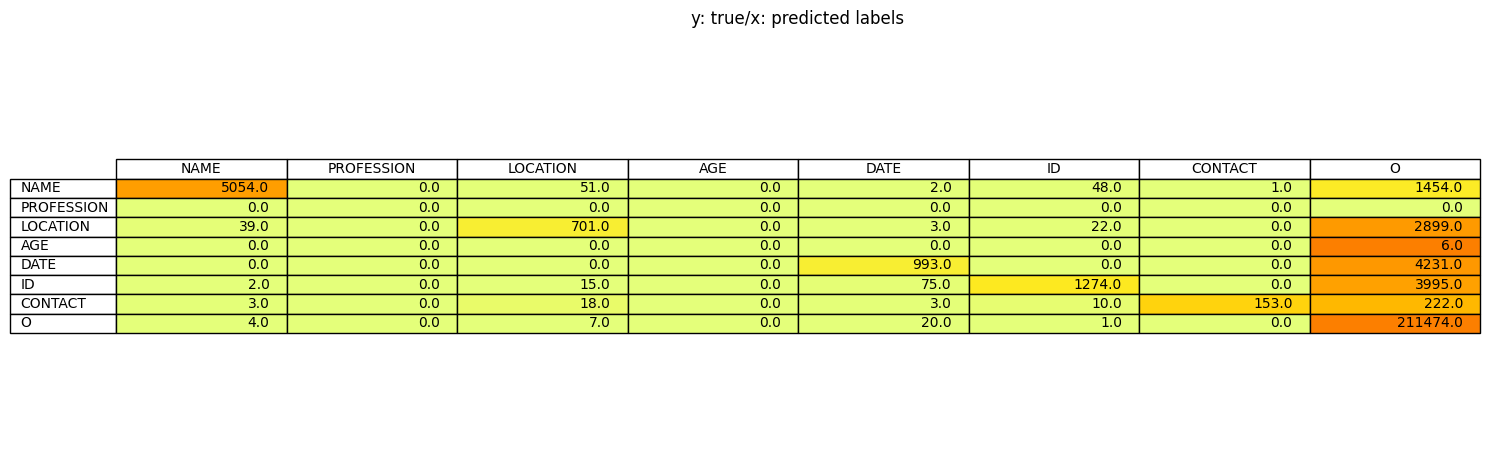

Wrongly predicted examples:
_____ Record 536 _____
| Sentence:    | 405728860 | fih      | 7150860 25532 / 83f7 805510 | 11 / 26 | / 1992 12 : 00 : 00 am hepatic cyst. unsigned dis report status : unsigned admission date : | 11 - 26 | - 92 discharge date : | 12 - 04 | - 92 principal diagnosis : hepatic cyst. associated diagnosis : 1. history of colon cancer, 2. elevated carcinoembryogenic antigen. special procedures and operations : | 11 - 28 | - 92, exploratory laparotomy, lysis of adhesions, biopsy of lymph nodes and small bowel mesentery and intraoperative ultrasound. history of present illness : the patient is a 65 year old female, status post a right colectomy for colon cancer, now with some question of hepatic metastases. she has received postoperative chemotherapy. she has had some right sided abdominal pain and apparently had a computerized tomography scan and magnetic resonance imaging study at an outside hospital that showed a question of hepatic metastases. she was referred 

In [16]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [17]:
stats.get_specific_failed_predictions('LOCATION')

Wrongly predicted examples:
_____ Record 510 _____
| Sentence:    | 405507617 | fih      | 2887168 132052 543394 | 11 / 12 | / 2002 12 : 00 : 00 am discharge summary unsigned dis report status : unsigned discharge summary name : | spaldfreiermplca, ieoly e | unit number : | 251 - 62 - 95 | admission date : | 11 / 12 | / 2002 discharge date : | 11 / 15 | / 2002 principal diagnosis : alzheimer's disease secondary to down's syndrome. chief complaint : this is a 44 year - old right handed woman with down's syndrome who presents with falling and a decrease in her activities of daily living. history of present illness : this is a 44 year - old right handed woman with down's syndrome who presents with increased falling and gait unsteadiness and an increased inability to perform her activities of daily living over the past three years. the diagnosis of alzheimer's was made in 1998. the patient had an mri at an outside hospital which showed enlarged lateral ventricles and the possible diagnosis

['111',
 '135',
 '151',
 '168',
 '177',
 '185',
 '194',
 '202',
 '206',
 '214',
 '220',
 '233',
 '420',
 '422',
 '423',
 '424',
 '426',
 '428',
 '429',
 '430',
 '431',
 '432',
 '436',
 '437',
 '438',
 '439',
 '440',
 '441',
 '442',
 '443',
 '444',
 '445',
 '446',
 '447',
 '448',
 '449',
 '450',
 '451',
 '453',
 '454',
 '455',
 '456',
 '457',
 '458',
 '459',
 '460',
 '461',
 '462',
 '463',
 '465',
 '466',
 '467',
 '469',
 '470',
 '471',
 '472',
 '473',
 '474',
 '475',
 '477',
 '478',
 '479',
 '480',
 '481',
 '482',
 '483',
 '484',
 '486',
 '487',
 '488',
 '489',
 '490',
 '491',
 '492',
 '493',
 '494',
 '495',
 '496',
 '498',
 '499',
 '500',
 '502',
 '503',
 '504',
 '505',
 '506',
 '507',
 '508',
 '509',
 '510',
 '511',
 '512',
 '513',
 '514',
 '515',
 '516',
 '517',
 '518',
 '519',
 '520',
 '521',
 '522',
 '523',
 '524',
 '525',
 '526',
 '527',
 '528',
 '529',
 '530',
 '531',
 '532',
 '533',
 '534',
 '535',
 '536',
 '537',
 '538',
 '539',
 '540',
 '541',
 '542',
 '543',
 '544',
 '545',


In [18]:
stats.get_specific_failed_predictions('ID')

Wrongly predicted examples:
_____ Record 457 _____
| Sentence:    | 026350193 | rwh      | 7093319 549304 8417371 | 6 / 5 | / 2002 12 : 00 : 00 am ed discharge summary unsigned dis report status : unsigned ed discharge notification / summary | aascoleslent, dirod | mrn : | 7093319 | age : 50y registration date : | 06 / 05 | / 2002 02 : 46 pm provider : | rybam shoulder | preliminary report pcp notified by md : left message with answering service or pcp office benefits assigned : y discharge date / time : | 06 / 05 | / 2002 16 : 17 discharge status : discharged condition on discharge : stable patient states complaint : l shoulder inj standardized discharge instructions : the patient was given printed instructions for neck strains ( english ). diagnosis : left shoulder / neck strain / sprain. treatment rendered : dilaudid 2mg po x 1 flexeril 10 mg x 1 discharge medications : flexeril 10mg tid disposition, follow up and instructions to patient : please follow - up with your orthopaedic ph

['111',
 '135',
 '151',
 '168',
 '177',
 '185',
 '194',
 '202',
 '206',
 '214',
 '220',
 '233',
 '420',
 '422',
 '423',
 '424',
 '426',
 '428',
 '429',
 '430',
 '431',
 '432',
 '436',
 '437',
 '438',
 '439',
 '440',
 '441',
 '442',
 '443',
 '444',
 '445',
 '446',
 '447',
 '448',
 '449',
 '450',
 '451',
 '453',
 '454',
 '455',
 '456',
 '457',
 '458',
 '459',
 '460',
 '461',
 '462',
 '463',
 '465',
 '466',
 '467',
 '469',
 '470',
 '471',
 '472',
 '473',
 '474',
 '475',
 '477',
 '478',
 '479',
 '480',
 '481',
 '482',
 '483',
 '484',
 '486',
 '487',
 '488',
 '489',
 '490',
 '491',
 '492',
 '493',
 '494',
 '495',
 '496',
 '498',
 '499',
 '500',
 '502',
 '503',
 '504',
 '505',
 '506',
 '507',
 '508',
 '509',
 '510',
 '511',
 '512',
 '513',
 '514',
 '515',
 '516',
 '517',
 '518',
 '519',
 '520',
 '521',
 '522',
 '523',
 '524',
 '525',
 '526',
 '527',
 '528',
 '529',
 '530',
 '531',
 '532',
 '533',
 '534',
 '535',
 '536',
 '537',
 '538',
 '539',
 '540',
 '541',
 '542',
 '543',
 '544',
 '545',


**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных: